In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import time
import os
import joblib
import torch.nn.functional as F


# 创建模型保存目录
os.makedirs("model", exist_ok=True)

In [2]:
# 自定义 RMSLE 损失函数
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true):
        y_pred = torch.clamp(y_pred, min=0)
        log_pred = torch.log1p(y_pred)
        log_true = torch.log1p(y_true)
        return torch.sqrt(torch.mean((log_pred - log_true) ** 2))

In [3]:
def load_train_dataset(file_path, save_scaler_path='model/scaler.pkl'):
    df = pd.read_csv(file_path)
    df = df.dropna()
    df = df.drop(columns=['id'])
    df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})

    x = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    scaler = MinMaxScaler()
    x_scaled = scaler.fit_transform(x)
    joblib.dump(scaler, save_scaler_path)

    x_scaled = x_scaled.astype(np.float32)
    y = y.astype(np.float32)

    dataset = TensorDataset(torch.tensor(x_scaled), torch.tensor(y.values))
    return dataset, x.shape[1]

def load_test_dataset(file_path, scaler_path='model/scaler.pkl'):
    df = pd.read_csv(file_path)
    df = df.dropna()
    df = df.drop(columns=['id'])
    df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})

    x = df.iloc[:, :]
    y = df.iloc[:, -1] if 'Price' in df.columns else pd.Series([0]*len(x))
    scaler = joblib.load(scaler_path)
    x_scaled = scaler.transform(x)

    x_scaled = x_scaled.astype(np.float32)
    y = y.astype(np.float32)

    dataset = TensorDataset(torch.tensor(x_scaled), torch.tensor(y.values))
    return dataset, x.shape[1]

In [4]:
class Model(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, 64)         # 增大第一层宽度
        self.bn1 = nn.BatchNorm1d(64)         # 批标准化，稳定训练
        self.dropout1 = nn.Dropout(0.2)       # 防止过拟合

        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.2)

        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.fc1(x)), negative_slope=0.01)
        x = self.dropout1(x)
        x = F.leaky_relu(self.bn2(self.fc2(x)), negative_slope=0.01)
        x = self.dropout2(x)
        return self.output(x)


In [5]:
# 训练模型
def train(train_dataset, dim, num_epoch):
    dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    model = Model(dim)
    criterion = RMSLELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=15, verbose=True
    )

    epoch_losses = []

    for epoch in range(num_epoch):
        model.train()
        total_loss = 0.0
        batch_num = 0
        start_time = time.time()

        for x, y in dataloader:
            y = y.unsqueeze(1)
            pred = model(x)
            loss = criterion(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            batch_num += 1
        # 动态调整学习率
        scheduler.step(loss)
        avg_loss = total_loss / batch_num
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Time: {time.time() - start_time:.2f}s")

    # 保存模型
    torch.save(model.state_dict(), 'model/model.pth')
    print("模型已保存到 model/model.pth")

    # 绘制 loss 曲线
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epoch + 1), epoch_losses, marker='o')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('RMSLE Loss')
    plt.grid(True)
    plt.savefig('model/loss_curve.png')
    plt.show()


# 测试模型
def test(test_dataset, dim):
    dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)
    model = Model(dim)
    model.load_state_dict(torch.load('model/model.pth'))
    model.eval()

    predictions = []
    with torch.no_grad():
        for x, _ in dataloader:
            y_pred = model(x)
            predictions.extend(y_pred.squeeze().tolist())

    print("测试集预测完成，前10个结果：", predictions[:10])
    return predictions


/Users/stanyan/.pyenv/versions/3.12.0/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Loss: 0.3245, Time: 48.92s
Epoch 2, Loss: 0.2878, Time: 46.67s
Epoch 3, Loss: 0.2873, Time: 46.86s
Epoch 4, Loss: 0.2863, Time: 57.39s
Epoch 5, Loss: 0.2861, Time: 52.06s
Epoch 6, Loss: 0.2855, Time: 56.82s
Epoch 7, Loss: 0.2860, Time: 65.73s
Epoch 8, Loss: 0.2856, Time: 48.88s
Epoch 9, Loss: 0.2864, Time: 49.17s
Epoch 10, Loss: 0.2860, Time: 46.28s
模型已保存到 model/model.pth


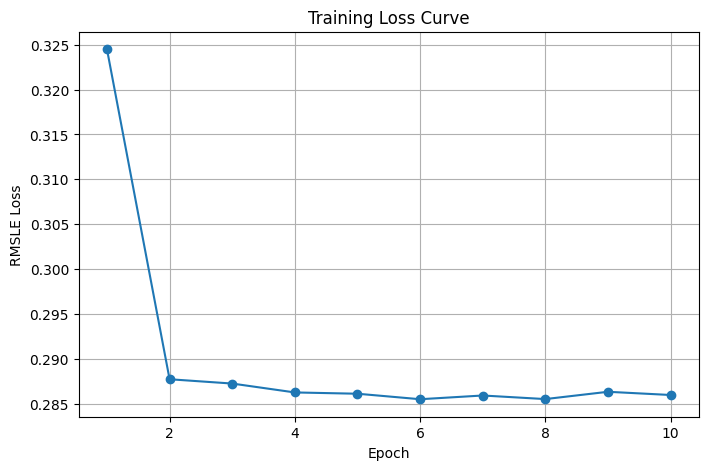

测试集预测完成，前10个结果： [26.73310089111328, 96.3408432006836, 81.95387268066406, 115.31420135498047, 70.97073364257812, 18.701309204101562, 46.512184143066406, 7.978865146636963, 7.9970502853393555, 200.14306640625]


In [6]:
# 主程序
if __name__ == '__main__':
    train_dataset, dim = load_train_dataset('data/train.csv')
    test_dataset, _ = load_test_dataset('data/test.csv')
    
    train(train_dataset, dim, num_epoch=10)
    test(test_dataset, dim)